# Author: Lukas Krasnoborov 11/11/224

##### **In this notebook the data will be applied on both the Categorical dataset and the Binary one (Dataset 1 and 2)** 

The string variants of the datasets were to be used on decision trees, as stated in the presentations, however, the scikit-learn decision trees require numerical data, thus the original numerical datasets will be used

## Necessary Imports

In [20]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

#Decision trees and model training/evaluation 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

import numpy as np
import os
import pandas as pd

#to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Loading in datasets

In [21]:
#Function returns a dataframe based on file path
def load_dataset(base_path, filename):

  file_path = os.path.join(base_path, filename)
      
  #Check if the file exists
  if os.path.exists(file_path):
    print(f"Loading dataset from {file_path}")
    return pd.read_csv(file_path)
  else:
    print(f"File not found at {file_path}")
    return None

#Defining paths to datasets
_2_PATH = "../datasets/2_categorical/processed"
_1_PATH = "../datasets/1_binary/processed"

#Loading csv filed as panda dataframes
_1_og_b = load_dataset(_1_PATH, "1_og_b.csv")
_1_og_ub = load_dataset(_1_PATH, "1_og_ub.csv")
_2_og = load_dataset(_2_PATH,"2_og.csv")
_1_ef_b = load_dataset(_1_PATH, "1_ef_b.csv")

#Verify imports
#_1_og_b.head()
#_1_og_ub.head()
#_1_ef_b.head()
_2_og.head()

Loading dataset from ../datasets/1_binary/processed/1_og_b.csv
Loading dataset from ../datasets/1_binary/processed/1_og_ub.csv
Loading dataset from ../datasets/2_categorical/processed/2_og.csv
Loading dataset from ../datasets/1_binary/processed/1_ef_b.csv


,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,Occupational Hazards,Genetic Risk,Chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,1
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,2
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,3
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,3
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,3


# **Building Decision Trees**

## Binary Dataset

First, I want to compare the performance of unbalanced vs balanced datasets on the decision trees model.

I am going to run the deciosion tree classifier on the binary original unbalanced dataset variation, then on the binary original balanced dataset variation and compare the results.

#### Decision Tree (Default parameters) on 1_og_ub variation:

Accuracy: 0.9247311827956989

Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.57      0.53         7
           2       0.96      0.95      0.96        86

    accuracy                           0.92        93
   macro avg       0.73      0.76      0.75        93
weighted avg       0.93      0.92      0.93        93



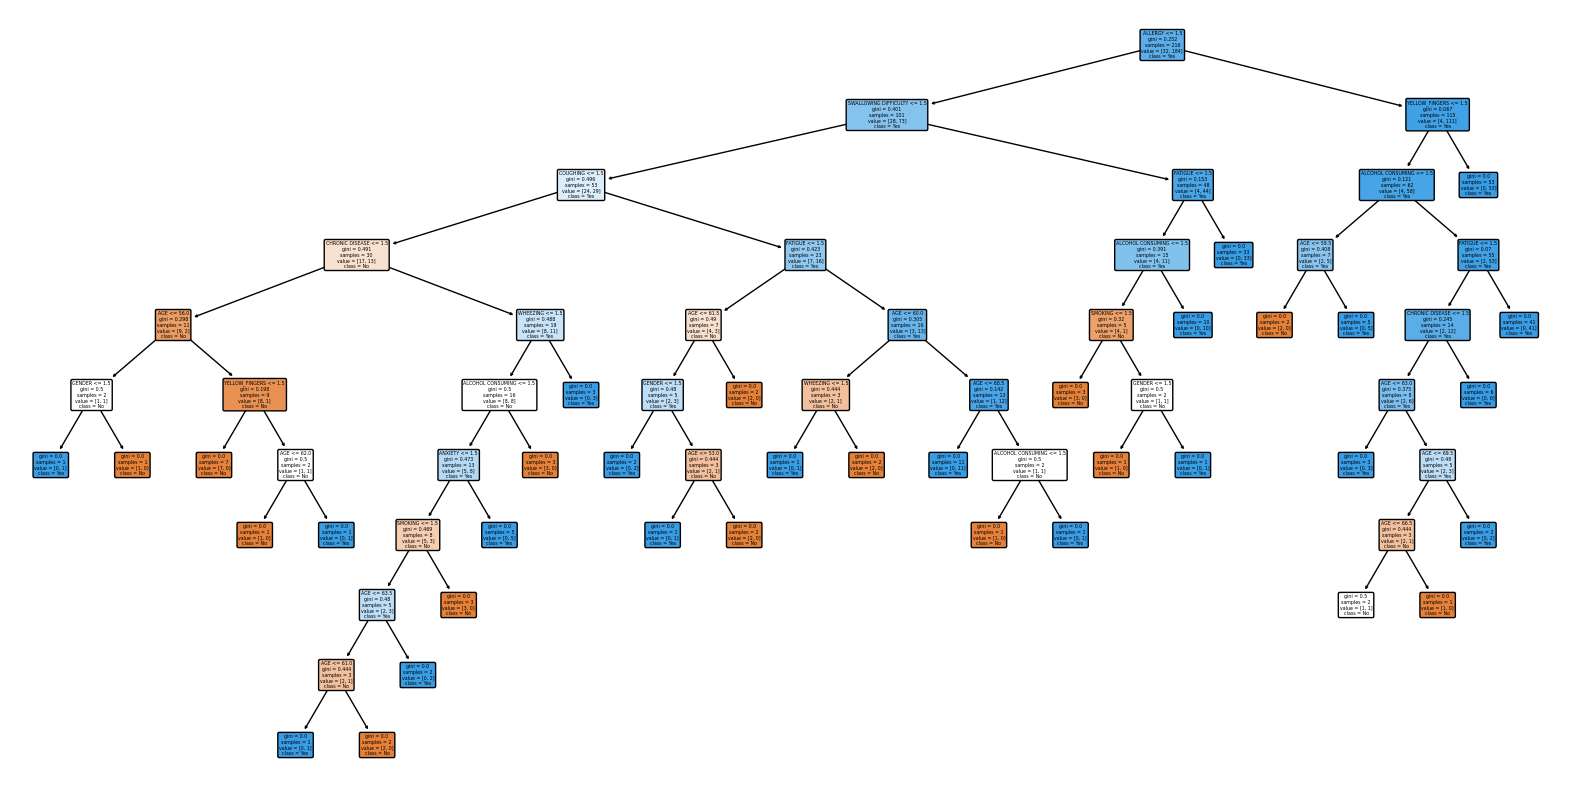

In [22]:
#Separate features and taget
X_og_ub = _1_og_ub.drop(columns=['LUNG_CANCER'])  #Features
y_og_ub = _1_og_ub['LUNG_CANCER']  #Target


#Train test split
X_og_ub_train, X_og_ub_test, y_og_ub_train, y_og_ub_test = train_test_split(X_og_ub, y_og_ub, test_size=0.3, random_state=42)

#Configure decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

#Train model
dt_model.fit(X_og_ub_train, y_og_ub_train)

#Predict on the test set
y_og_ub_pred = dt_model.predict(X_og_ub_test)

#Evaluate model and print results
print("Accuracy:", accuracy_score(y_og_ub_test, y_og_ub_pred)) # display accuracy score
print("\nClassification Report:\n", classification_report(y_og_ub_test, y_og_ub_pred)) # display more results

#Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_og_ub.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

The model achieved an overall high accuracy score of 92.5%. However, this can be misleading due to the unbalance and the heavy influence of majority class.

The high precision, recallm and F-1 scores (0.96,0.98,0,97) for the majority class (86 isntances "Yes") means that the model is very good at identifying these instances. There is a low amount of false negatives.

For the minority class(7 instances "No"), the precision (0.5), recall (0.57), f-1 score (0.53) are relatively low, there is a high amount of False Positives.

The imbalance in the dataset clearly shows itself in the results from the model. The macro and weighted avg also indicate that the the majory class has disproportionate influence.

Looking at the tree visualization, the tree has a relatively deep structure, going 9 layers deep. Deep structures are prone to overfitting, performing worse on the testing examples (which is seen for the minority class).

Towards the root, the tree tends to split on features that are more correlated to the target class, such as Allergy and Swallowing difficulty. Towards the leaf nodes, it tends to split on less correlated features such as Age.

The imbalance of the data can be seen in the decision tree. Most nodes are colored blue, which is for the "yes" class.

##### Verifying through cross-validation

In [23]:
#Configure decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

#Perform 5-fold cross-validation
cv_scores = cross_val_score(dt_model, X_og_ub, y_og_ub, cv=5, scoring='accuracy')

# Output the cross-validation results
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))

5-Fold Cross-Validation Accuracy Scores: [0.87096774 0.85483871 0.93548387 0.82258065 0.90163934]
Mean Accuracy: 0.8771020624008461
Standard Deviation of Accuracy: 0.03877211748811008


Cross-validation releals that the original run was more on the optimistic side/ The average accuracy is noticably lower, from 92.4% to 88.7%

#### Decision Tree (Default parameters) on 1_og_b variation:

Accuracy: 0.9506172839506173

Classification Report:
               precision    recall  f1-score   support

           1       0.90      1.00      0.95        72
           2       1.00      0.91      0.95        90

    accuracy                           0.95       162
   macro avg       0.95      0.96      0.95       162
weighted avg       0.96      0.95      0.95       162



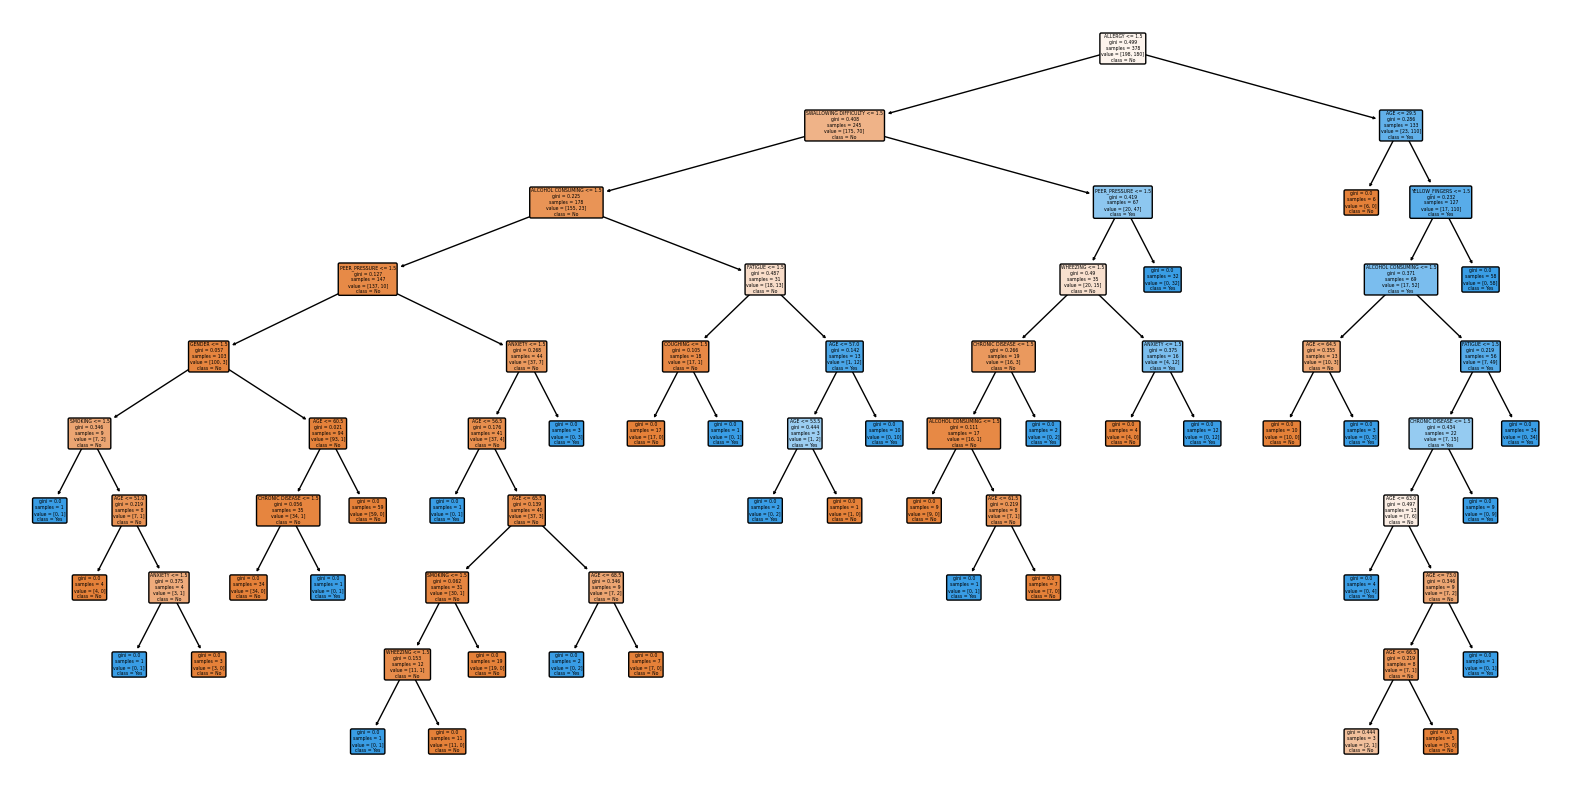

In [24]:
#Separate features and taget
X_og_b = _1_og_b.drop(columns=['LUNG_CANCER'])  #Features
y_og_b = _1_og_b['LUNG_CANCER']  # target

#Train test split
X_og_b_train, X_og_b_test, y_og_b_train, y_og_b_test = train_test_split(X_og_b, y_og_b, test_size=0.3, random_state=42)

#Configure classifier
dt_model = DecisionTreeClassifier(random_state=42)

#Train model
dt_model.fit(X_og_b_train, y_og_b_train)

#Ppredict on the test set
y_og_b_pred = dt_model.predict(X_og_b_test)

#Evaluate model and print results
print("Accuracy:", accuracy_score(y_og_b_test, y_og_b_pred)) # display accuracy score
print("\nClassification Report:\n", classification_report(y_og_b_test, y_og_b_pred)) # display more results

#Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_og_b.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

The accuracy of the model is 95%, which is comparable to the unbalanced dataset.

However, this time the precision, recall and f1-scores are 90-100% for both the "No" and the "Yes" class.

The models recalls 100% of the "No" class and only 90% for the "Yes" class, meaning that 10% of cancer cases are not detected. The high value for the "no" class likely comes from the oversampling, as all instances in the test set were previously encountered in the training set. The model may not generalize well.

Overall, this is a tradeoff that has to be considered in practical scenarios. Ideally, data should be collected to represent the classes equally. For further exploration, the balanced dataset will be used.

The decision tree produced has a similar depth and splits similarly to the one produced for the unbalanced data. However, it has a much more equal split between the classes, seen by the coloring of the tree (a lot more orange and higher saturation).

Another thing that can be said about the trees, is that the higher end for most splits (0.3-0.5), which is not surprising, as the features in this dataset are not strongly correlated to the target class.

#### Decision Tree Pruning

Next, I explore pruning the decision tree and its impact on the metrics

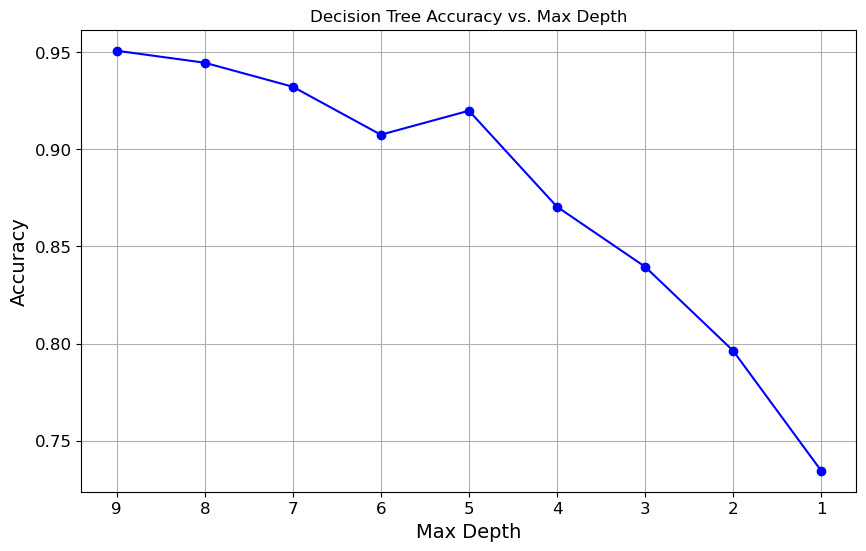

   Max Depth  Accuracy
0          9  0.950617
1          8  0.944444
2          7  0.932099
3          6  0.907407
4          5  0.919753
5          4  0.870370
6          3  0.839506
7          2  0.796296
8          1  0.734568


In [25]:
#List to store results at different depth
depth_accuracy = []

#Get accuracies for different depths (from 9 to 1)
for depth in range(9, 0, -1):
   
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_og_b_train, y_og_b_train)
    
    y_pred = dt_model.predict(X_og_b_test)
    
    accuracy = accuracy_score(y_og_b_test, y_pred)
    depth_accuracy.append({"Max Depth": depth, "Accuracy": accuracy})


accuracy_df = pd.DataFrame(depth_accuracy)

#Display results as a graph
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df["Max Depth"], accuracy_df["Accuracy"], marker='o', linestyle='-', color='b')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. Max Depth")
plt.gca().invert_xaxis() 
plt.grid(True)
plt.show()

#Display the accuracy table
print(accuracy_df)

By calculating the accuracy scores for different depth and plotting the result on a graph, a cosnsitent reduction in accuracy can be observed when reducing the depth.

There is a small loss of accuracy from a depth of 10 to a depth of 5, going from 95% to 92%. A tree of depth 5 performs slightly better than a tree of depth 6.

Further reductions in depth result in a noticable and accelerating loss of performance, going all the way down to 73% at a depth of 1.

The best tradeoff happens at at depth 5, with only a 3% decrease in accuracy and a significant reduction in computation and overfitting. 

Next, the tree with depth five is explored further

Accuracy: 0.9197530864197531

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.97      0.92        72
           2       0.98      0.88      0.92        90

    accuracy                           0.92       162
   macro avg       0.92      0.93      0.92       162
weighted avg       0.93      0.92      0.92       162



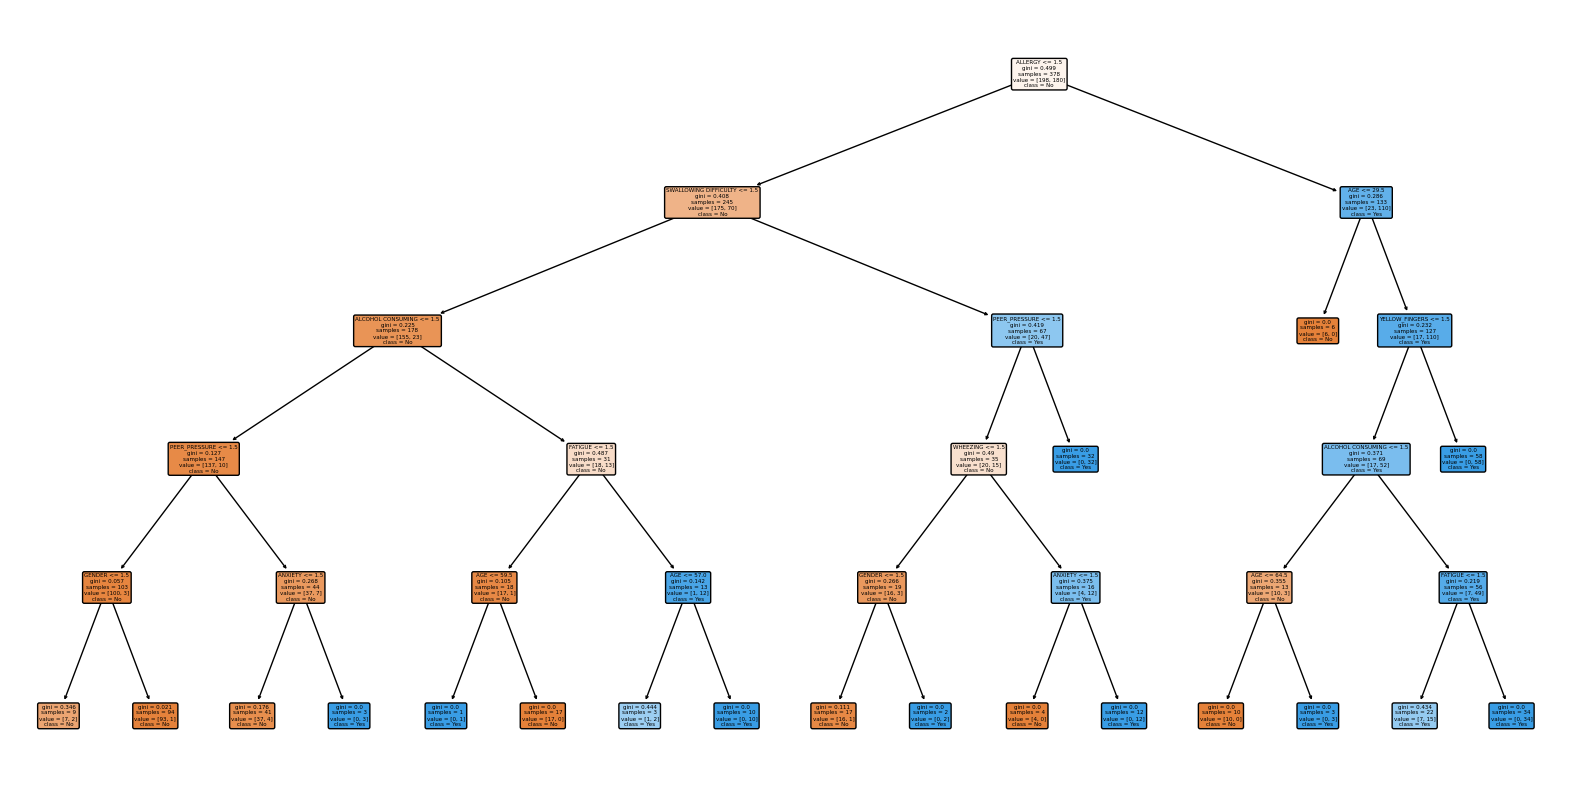

In [26]:
#Configure classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

#Train model
dt_model.fit(X_og_b_train, y_og_b_train)

#Predict on test set
y_og_b_pred = dt_model.predict(X_og_b_test)

#Evaluate model
print("Accuracy:", accuracy_score(y_og_b_test, y_og_b_pred)) # display accuracy score
print("\nClassification Report:\n", classification_report(y_og_b_test, y_og_b_pred)) # display more results

#Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_og_b.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

There is no significant change in the dynamic of precision and recall scores between the two classes. As expected, there is a reduction in precision and recall by 2% for both classes. Considering that over half the nodes were removed, this is a positive result. 

The tree structure did not change, and the nodes and splits are the same from the root node to the 5th depth. The tree was simply pruned at depth 5. This means that adding more depth was largely overfitting.

#### Comparison with feature extraxted dataset

Another variation of the dataset was made by combining features together, which resulted in features that correlate better with the target class. The balanced version of this variation will be used with a depth of 5, to analyse how this type feature extraction affects decision tree model performance.

Accuracy: 0.8271604938271605

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.97      0.83        72
         1.0       0.97      0.71      0.82        90

    accuracy                           0.83       162
   macro avg       0.85      0.84      0.83       162
weighted avg       0.86      0.83      0.83       162



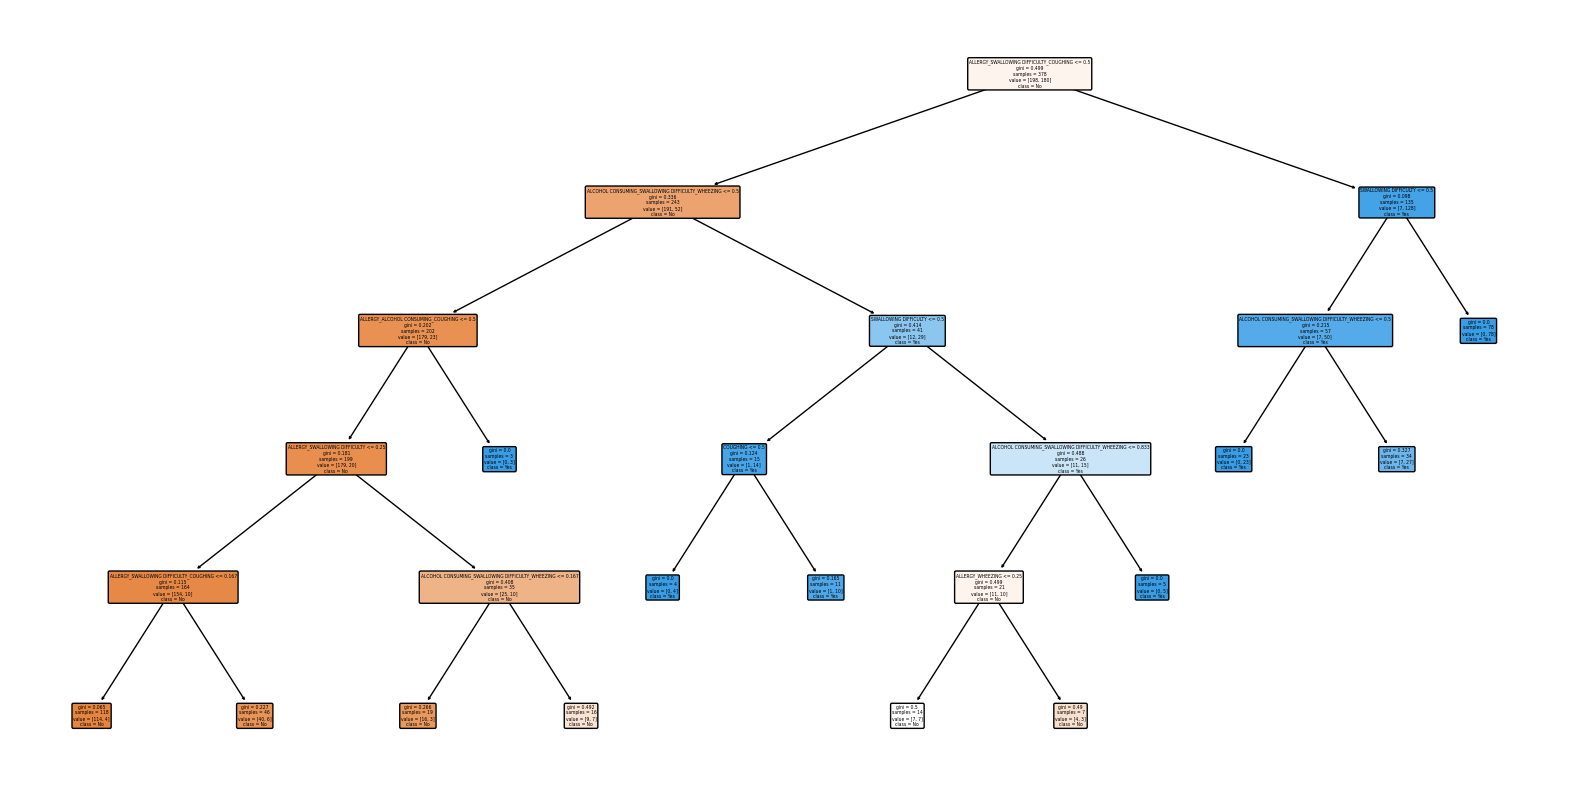

In [27]:
#Separate features and taget
X_ef_b = _1_ef_b.drop(columns=['LUNG_CANCER'])  # features
y_ef_b = _1_ef_b['LUNG_CANCER']  # target

#Train test split
X_ef_b_train, X_ef_b_test, y_ef_b_train, y_ef_b_test = train_test_split(X_ef_b, y_ef_b, test_size=0.3, random_state=42)

#Configure classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# train model
dt_model.fit(X_ef_b_train, y_ef_b_train)

# predict on the test set
y_ef_b_pred = dt_model.predict(X_ef_b_test)

# evaluate model
print("Accuracy:", accuracy_score(y_ef_b_test, y_ef_b_pred)) # display accuracy score
print("\nClassification Report:\n", classification_report(y_ef_b_test, y_ef_b_pred)) # display more results

# visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_ef_b.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

This model performed noticably worse, with a reduction in accuracy of 9%, down to 82%. This is likely due to the fact that the extracted features include only the combinations between most correlated features, leaving out 10/15 features from the orginal dataset. This means that even the lesser correlated features meaningfully contributed to correct classification in the case of decision trees for this dataset.

The biggest issue is recall being 70% for the 'Yes' class, meaning that there is a significant amount of false negatives, which is significant for real life applications.

#### Veryfiyng best dataset variation and depth through cross validation

In [28]:
#Configure the Decision Tree model with max_depth = 4
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

#Perform 5-fold cross-validation on the model
cv_scores = cross_val_score(dt_model, X_og_b, y_og_b, cv=5, scoring='accuracy')

#Calculate and display the mean and standard deviation of the cross-validation scores
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))

5-Fold Cross-Validation Accuracy Scores: [0.9537037  0.92592593 0.92592593 0.87962963 0.91666667]
Mean Accuracy: 0.9203703703703704
Standard Deviation of Accuracy: 0.02385944208652801


Cross validation confirms the accuracy for the original balanced dataset with an average accuracy of 92% and a standard deviation of 2%.

The differences across the different folds are noticable, with the best being 95% and the wors being 88%. 

Overall, this is a solid performance that meets the balance betweeen a reasonable tree depth and a strong accuracy score.

## Categorcial Dataset

For the categorical dataset, with the possible target class ('Level'), target values ('Low','Medium','High') are well balanced initially. Multiple features are strongly correlated with the target class, so no feature extraction was performed.

First, accuracies for different depth is investigated

#### Exploring Tree Depth

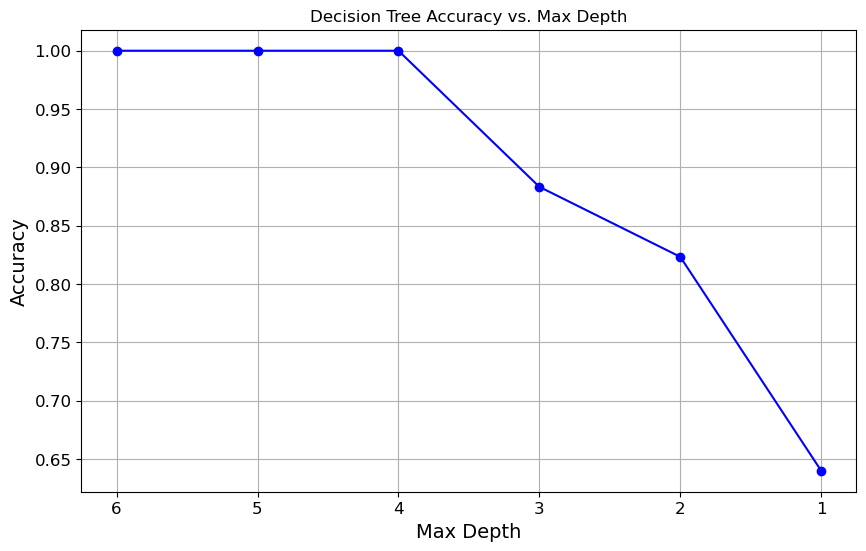

In [29]:
#Separate features and target
X_2 = _2_og.drop(columns=['Level'])  #Features
y_2 = _2_og['Level']  #Target

#Split the data into training and testing sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

#List to store results at different depth
depth_accuracy = []

#Get accuracies for different depths (from 6 to 1)
for depth in range(6, 0, -1):
   
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_2_train, y_2_train)
    
    y_2_pred = dt_model.predict(X_2_test)
    
    accuracy = accuracy_score(y_2_test, y_2_pred)
    depth_accuracy.append({"Max Depth": depth, "Accuracy": accuracy})


accuracy_df = pd.DataFrame(depth_accuracy)

#Display results as a graph
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df["Max Depth"], accuracy_df["Accuracy"], marker='o', linestyle='-', color='b')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. Max Depth")
plt.gca().invert_xaxis()  
plt.grid(True)
plt.show()

For this dataset, the accuracy peaks at 100% for depth 4 and does not improve further by increasing the depth. Decreasing the depth results in a sharp decrease below 90% and continues downwards with further reductions. Therefore the best depth is 4.

#### Analyzing best depth

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00       119

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



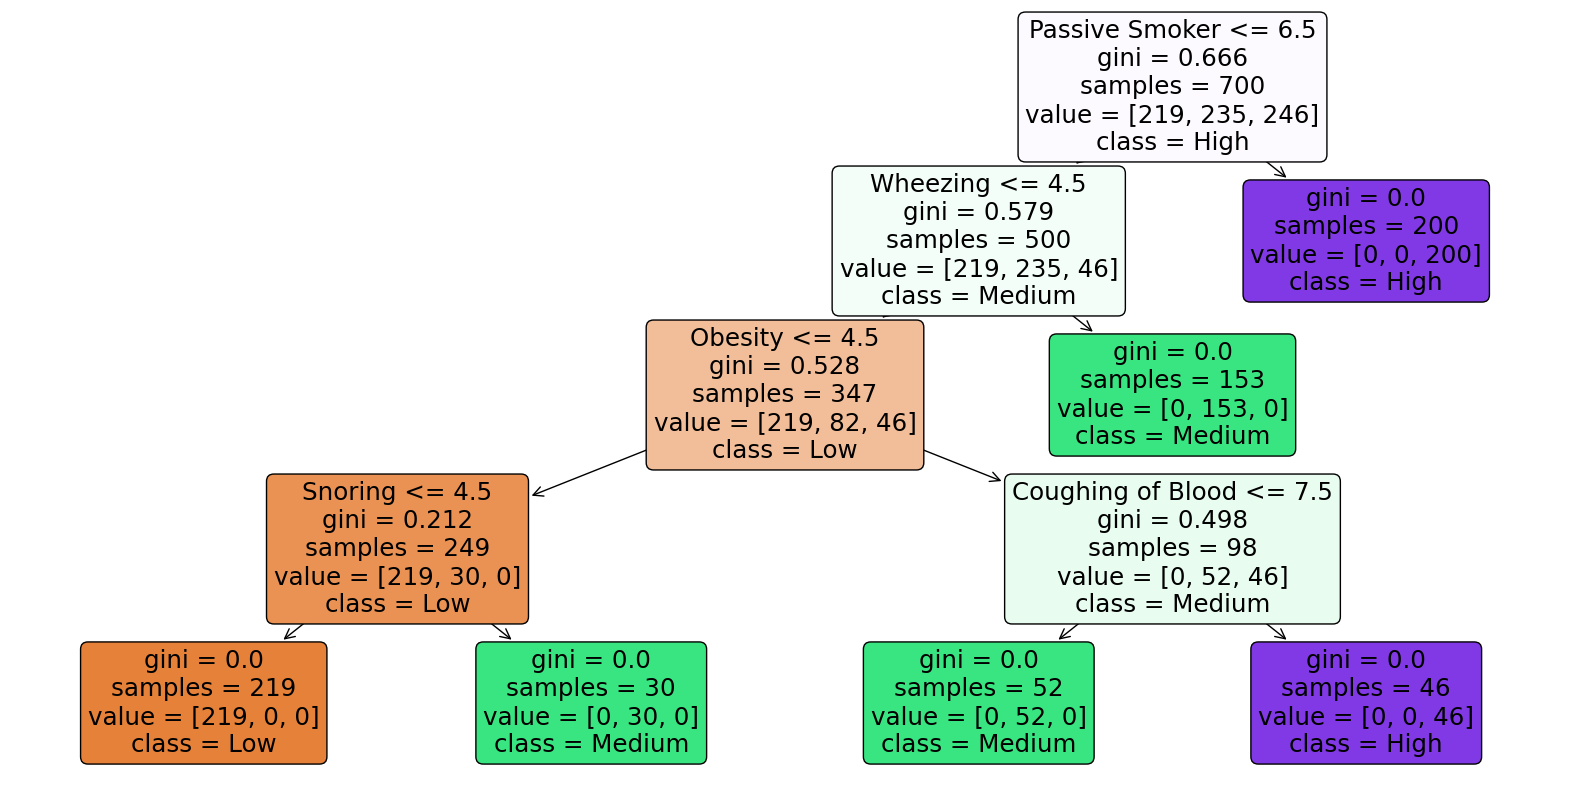

In [30]:
#Configure classifier with depth 4
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)

#Train model
dt_model.fit(X_2_train, y_2_train)

#Predict on the test set
y_2_pred = dt_model.predict(X_2_test)

#Evaluate model
print("Accuracy:", accuracy_score(y_2_test, y_2_pred)) # display accuracy score
print("\nClassification Report:\n", classification_report(y_2_test, y_2_pred)) # display more results

#Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_2.columns, class_names=['Low', 'Medium','High'], filled=True, rounded=True)
plt.show()

Decision Tree Model for the categorical dataset achieved an accuracy of 100%, with recall, precision and f-1 score of 100%

This means that all instances were classified correctly. This has probably to do with the following:

1. There are features with strong correlations to the target class
2. The way the dataset is put together is to assign a risk level based on certain criteria. This could be not an observation of occurences, like in the binary dataeset, but inferred understanding/estimation.

The gini index is at 0 for multiple criteria, suggesting that if certain criteria are met above or below a certain threshold, it is a definiting characterisk for a certain risk level. Being a highly passive smoker (rating of 7 or higher) immediately puts a person in the 'High' risk category. If that is not the case, having symptoms of wheezing at 5 or above puts you in the medium category and so on. 

#### Confirming through cross-validation

In [31]:
#Cofigure decision tree with max_depth = 4
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)

#Perform 5-fold cross-validation on the model
cv_scores = cross_val_score(dt_model, X_2, y_2, cv=5, scoring='accuracy')

# Calculate and display the mean and standard deviation of the cross-validation scores
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))

5-Fold Cross-Validation Accuracy Scores: [0.985 0.99  0.99  0.995 1.   ]
Mean Accuracy: 0.992
Standard Deviation of Accuracy: 0.00509901951359279


By performing cross validation, we can see that this model is not always perfect, however, is very close to it.

In most runs the accuracy is 99%, not 100%, with some misclassifications. 